# Penguin species classification model generation

This notebook provides a walkthrough on creating a 2-layer neural network based classification model to classify Penguins in to three different species based on physical characteristics of the penguins. The data is obtained from the seaborn package. This is an example of a tabular data based classification model. Keras is used to create the neural network and the final model is converted and saved in ONNX format. This model is largely inspired by the [Introduction to Deep Learning](https://carpentries-incubator.github.io/deep-learning-intro/2-keras.html) carpentries lesson.

In [2]:
import seaborn as sns
import pandas as pd

### Load the dataset

In [3]:
penguins = sns.load_dataset('penguins')

## Prepare the data

In [4]:
# Remove categorial columns and NaN values
penguins_filtered = penguins.drop(columns=['island', 'sex']).dropna()

In [5]:
# Extract inputs and target
input_features = penguins_filtered.drop(columns=['species'])
target = pd.get_dummies(penguins_filtered['species'])

In [6]:
# Let's explore the features of the dataset
input_features

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0
...,...,...,...,...
338,47.2,13.7,214.0,4925.0
340,46.8,14.3,215.0,4850.0
341,50.4,15.7,222.0,5750.0
342,45.2,14.8,212.0,5200.0


The data-set currently has four features that will be used to train the model: bill length, bill depth, flipper length, and body mass. These features will be used to classify the different species.

## Training and test data split

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(input_features, target, test_size=0.2, random_state=0, shuffle=True, stratify=target)

## Build & Compile Keras Model

In [6]:
from tensorflow import keras

def penguin_model():
    # Input layer
    inputs = keras.Input(shape=X_train.shape[1])

    # 1st hidden fully connected layer
    hidden_layer = keras.layers.Dense(10, activation="relu")(inputs)

    # Output layer
    output_layer = keras.layers.Dense(3, activation="softmax")(hidden_layer)

    # Create model
    model = keras.Model(inputs=inputs, outputs=output_layer)
    return model

model = penguin_model()
model.summary()

2023-11-08 10:58:27.399381: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-08 10:58:27.401086: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-08 10:58:27.438268: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-08 10:58:27.439863: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-08 10:58:28.114692: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 3)                 33        
                                                                 
Total params: 83
Trainable params: 83
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Compile model
model.compile(optimizer='adam', loss=keras.losses.CategoricalCrossentropy())

## Train the model

In [8]:
history = model.fit(X_train, y_train, epochs=100)

Epoch 1/100
9/9 [==============================] - 0s 2ms/step - loss: 2614.4949
Epoch 2/100
9/9 [==============================] - 0s 2ms/step - loss: 2447.2056
Epoch 3/100
9/9 [==============================] - 0s 2ms/step - loss: 2282.9285
Epoch 4/100
9/9 [==============================] - 0s 2ms/step - loss: 2127.1621
Epoch 5/100
9/9 [==============================] - 0s 2ms/step - loss: 1979.8400
Epoch 6/100
9/9 [==============================] - 0s 2ms/step - loss: 1837.2648
Epoch 7/100
9/9 [==============================] - 0s 2ms/step - loss: 1695.2177
Epoch 8/100
9/9 [==============================] - 0s 2ms/step - loss: 1559.1316
Epoch 9/100
9/9 [==============================] - 0s 2ms/step - loss: 1429.3796
Epoch 10/100
9/9 [==============================] - 0s 2ms/step - loss: 1305.7759
Epoch 11/100
9/9 [==============================] - 0s 2ms/step - loss: 1197.8348
Epoch 12/100
9/9 [==============================] - 0s 2ms/step - loss: 1089.3776
Epoch 13/100
9/9 [=======

## Test the model

In [9]:
y_pred = model.predict(X_test)
prediction = pd.DataFrame(y_pred, columns=target.columns)
predicted_species = prediction.idxmax(axis="columns")

3/3 [==============================] - 0s 3ms/step


<Axes: xlabel='Predicted Label', ylabel='True Label'>

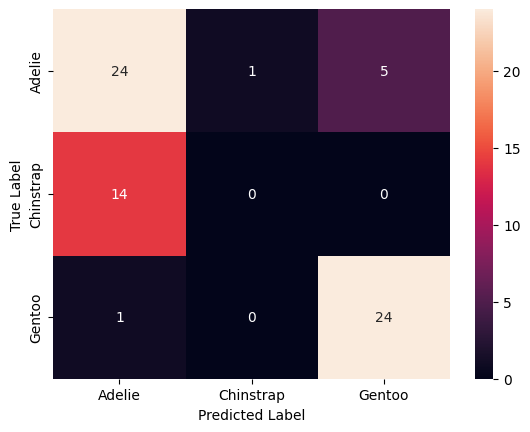

In [10]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix

true_species = y_test.idxmax(axis="columns")

matrix = confusion_matrix(true_species, predicted_species)

# Convert to a pandas dataframe
confusion_df = pd.DataFrame(matrix, index=y_test.columns.values, columns=y_test.columns.values)

# Set the names of the x and y axis, this helps with the readability of the heatmap.
confusion_df.index.name = 'True Label'
confusion_df.columns.name = 'Predicted Label'

sns.heatmap(confusion_df, annot=True)

## Convert to ONNX and save model

In [11]:
import tf2onnx

output_path = 'penguin_model.onnx'
tf2onnx.convert.from_keras(model, opset=13, output_path=output_path)

2023-11-08 10:58:43.083279: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-11-08 10:58:43.083488: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-11-08 10:58:43.104968: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-11-08 10:58:43.105238: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session


(ir_version: 7
 producer_name: "tf2onnx"
 producer_version: "1.15.1 12a3ba"
 graph {
   node {
     input: "input_1"
     input: "model/dense/MatMul/ReadVariableOp:0"
     output: "model/dense/MatMul:0"
     name: "model/dense/MatMul"
     op_type: "MatMul"
   }
   node {
     input: "model/dense/MatMul:0"
     input: "model/dense/BiasAdd/ReadVariableOp:0"
     output: "model/dense/BiasAdd:0"
     name: "model/dense/BiasAdd"
     op_type: "Add"
   }
   node {
     input: "model/dense/BiasAdd:0"
     output: "model/dense/Relu:0"
     name: "model/dense/Relu"
     op_type: "Relu"
   }
   node {
     input: "model/dense/Relu:0"
     input: "model/dense_1/MatMul/ReadVariableOp:0"
     output: "model/dense_1/MatMul:0"
     name: "model/dense_1/MatMul"
     op_type: "MatMul"
   }
   node {
     input: "model/dense_1/MatMul:0"
     input: "model/dense_1/BiasAdd/ReadVariableOp:0"
     output: "model/dense_1/BiasAdd:0"
     name: "model/dense_1/BiasAdd"
     op_type: "Add"
   }
   node {
     i

## Test the saved ONNX model

In [12]:
from dianna.utils.onnx_runner import SimpleModelRunner
import numpy as np
loaded_model = SimpleModelRunner(output_path)
penguin_train_x_numpy = X_train.to_numpy().astype(np.float32)
predictions = loaded_model(penguin_train_x_numpy)
print(np.allclose(model.predict(penguin_train_x_numpy), predictions))


9/9 [==============================] - 0s 2ms/step
True
